In [1]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

from data.datasets import PureCompoundsInTallCuvettes, COLOR_DICT
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform, StaticShiftTransform
from data.plot_functions import plot_array_data, plot_confusion_matrix
from data.utils import train_test_split, sort_by_set

SEED = 378 #660 #596 #534 #463 #378 #184 #156 #149

In [2]:
exp_set = PureCompoundsInTallCuvettes()
train_set, test_set = train_test_split(exp_set, seed=SEED)

## Temporal analysis

Load data

In [3]:
psi_derivs, labels = DataLoader(exp_set, transforms=[DerivTransform, NormalizeTransform]).load()
psi_derivs_not_norm, _ = DataLoader(exp_set, transforms=[DerivTransform]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76
Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===============

#### Calculate SVM

In [4]:
def predict(clf, test, lbl):
    predicted = clf.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")
    return predicted

In [5]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(psi_derivs, train_set, test_set)

##### Find best fitting SVM classifier

In [6]:
param_grid = {"kernel":("linear", "rbf"), "C":[0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]}

clf = GridSearchCV(svm.SVC(), param_grid, cv=LeaveOneOut())
clf.fit(train_data, train_lbl)

print(clf.best_params_)

best_scores = cross_val_score(clf.best_estimator_, train_data, train_lbl, scoring="accuracy", cv=LeaveOneOut())
print("Accuracy: %0.2f accuracy with a standard deviation of %0.2f" % (best_scores.mean(), best_scores.std()))

{'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Accuracy: 0.78 accuracy with a standard deviation of 0.41


In [7]:
SVC = svm.SVC(**clf.best_params_)
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 1.0 (50)


In [8]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.885 (23/26)

Mismatches (true, pred): [('Octane', 'Heptane'), ('Nonane', 'Decane'), ('Acetonitrile', 'Ethanol')]


#### Plot

Validation accuracy: 0.885 (23/26)


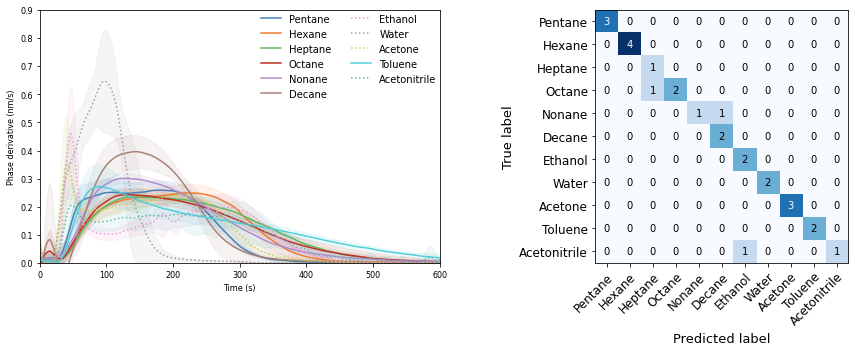

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs_not_norm, [0,600], ylim=[0,0.9], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes[0].set_ylabel("Phase derivative (nm/s)")

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()
# fig.savefig('./Fig3 - Temporal analysis.svg', dpi=1200)

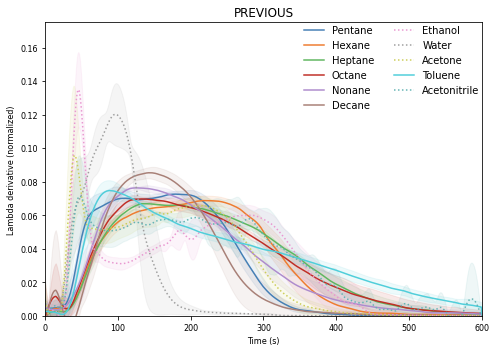

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs, [0,600], ylim=[0,0.175], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes)
axes.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes.set_ylabel("Lambda derivative (normalized)")

#from IPython.utils import io
#with io.capture_output() as captured:
# plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])
plt.title("PREVIOUS")

plt.tight_layout()
# fig.savefig('./Fig3 - Temporal analysis.svg', dpi=1200)

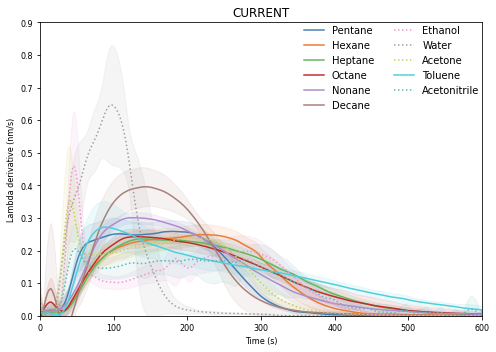

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs_not_norm, [0,600], ylim=[0,0.9], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes)
axes.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes.set_ylabel("Lambda derivative (nm/s)")

#from IPython.utils import io
#with io.capture_output() as captured:
# plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])
plt.title("CURRENT")

plt.tight_layout()
# fig.savefig('./Fig3 - Temporal analysis.svg', dpi=1200)

In [13]:
import pandas as pd

def coeff_variance(
    exp_set,
    input_data,
):

    for chem in exp_set:
        nums = exp_set[chem]
        data = pd.DataFrame([input_data[n] for n in nums])

        # calculate average
        avg = data.mean()
        std = data.std()

        coeff1 = np.array(std).max()/np.array(avg).max()
        coeff2 = std[np.argmax(avg)]/np.array(avg).max()
        coeff3 = np.array(std).mean()/np.array(avg).max()
        print(chem, f"max: {coeff1}, peak: {coeff2}, mean: {coeff3}, {std[np.argmax(avg)]}, {np.array(avg).max()}")

coeff_variance(exp_set, psi_derivs)

Pentane max: 0.13259699127176175, peak: 0.027067529152456787, mean: 0.04362849367562525, 0.0019642152608992497, 0.07256721697188853
Hexane max: 0.1485910231684482, peak: 0.043145044748540466, mean: 0.060261029608838036, 0.0029659768650265638, 0.0687443223738202
Heptane max: 0.07725451925521469, peak: 0.018684464821298024, mean: 0.033679492146991556, 0.0012504057624109007, 0.0669222144904889
Octane max: 0.31895784577380676, peak: 0.018196297355124333, mean: 0.06491120529741522, 0.0012680018326086207, 0.0696846071407782
Nonane max: 0.16687448239004588, peak: 0.011285998636271851, mean: 0.05509694179906497, 0.0008612440239380473, 0.0763108389159389
Decane max: 0.4204132702983832, peak: 0.039599889803561786, mean: 0.06687508938954992, 0.003378935623292251, 0.08532689459626565
Ethanol max: 0.1670328901030371, peak: 0.16613002764098864, mean: 0.03958482695402335, 0.022414563522172547, 0.13492180697526282
Water max: 0.30042214074069334, peak: 0.15482655381960148, mean: 0.042346836536629885, 0

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 0.9927272727272728 (0.010601730717900538)
Validation accuracy: 0.7690322580645162 (0.07805118521205993)


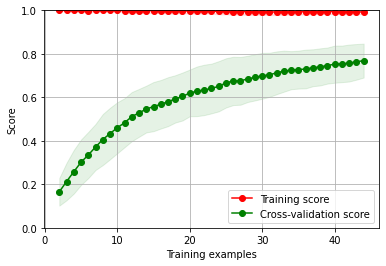

In [14]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_std = []
    test_mean = []
    test_std = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size, random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                estimator.fit(derivs, lbls);
                score = estimator.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(estimator.score(derivs, lbls))
                    test_score.append(estimator.score(test_derivs, test_lbl))
            else: 
                raise NotImplementedError

        train_mean.append(np.mean(train_score, axis=0))
        train_std.append(np.std(train_score, axis=0))
        test_mean.append(np.mean(test_score, axis=0))
        test_std.append(np.std(test_score, axis=0))

    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="lower right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(train_std[-1]) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(test_std[-1]) + ")")
    
    return test_mean, test_std, M

plot_learning_curve(SVC, [psi_derivs[k] for k in psi_derivs.keys()], [labels[k] for k in psi_derivs.keys()], ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None)
# plt.savefig('./Fig3 - Learning curve (SI).svg', dpi=1200)

In [18]:
for s in range(10000):
    param_grid = {"kernel":("linear", "rbf"), "C":[0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]}

    exp_set = PureCompoundsInTallCuvettes()
    train_set, test_set = train_test_split(exp_set, seed=s)

    train_data, train_lbl, test_data, test_lbl = sort_by_set(psi_derivs, train_set, test_set)

    clf = GridSearchCV(svm.SVC(), param_grid, cv=LeaveOneOut())
    clf.fit(train_data, train_lbl)

    SVC = svm.SVC(**clf.best_params_)
    SVC.fit(train_data, train_lbl)

    predicted = SVC.predict(test_data)
    if len([(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]) == 3 and "Heptane" not in set([lbl for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]):
        print(s)
    if set([(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]) == set([('Pentane', 'Nonane'), ('Octane', 'Nonane'), ('Acetonitrile', 'Ethanol')]):
        print(s, "match")
        break

38
69
109
110
149
156
176
184
196
238
292
330
341
370
378
410
463
493
534
537
596
598
610
646
660
681
690
697
773
824
878
886
919
923
925
969
1009
1017
1027
1074
1081
1108
1239
1242
1249
1263
1270
1275
1284
1299
1312
1338
1363
1367
1371
1467
1477
1521
1542
1544
1581
1602
1621
1641
1652
1655
1665
1677
1724
1745
1825
1831
1855
1858
1861
1863
1872
1882
1931
1954
1973
2006
2015
2025
2044
2088
2089
2094
2110
2116
2133
2148
2162
2202
2203
2206
2214
2219
2243
2260
2286
2312
2323
2329
2351
2359
2370
2420
2424
2427
2441
2495
2500
2503
2525
2542
2555
2559
2569
2572
2574
2590
2615
2698
2709
2722
2786
2793
2818


KeyboardInterrupt: 

Validation accuracy: 0.885 (23/26)
Accuracy: 0.885
Precision: 0.894
F1 Score: 0.885


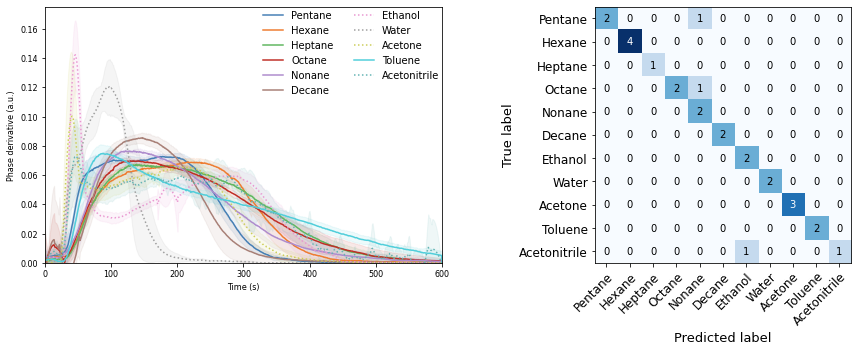

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs, [0,600], ylim=[0,0.175], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()

## Static analysis

Load data

In [40]:
static_shift, labels = DataLoader(exp_set, transforms=[StaticShiftTransform()]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76


#### Calculate SVM

In [41]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(static_shift, train_set, test_set)

In [42]:
SVC = svm.SVC(C=10,gamma=10, kernel="rbf")
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.78 (50)


In [43]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.308 (8/26)
Accuracy: 0.308
Precision: 0.303
F1 Score: 0.256

Mismatches (true, pred): [('Pentane', 'Ethanol'), ('Pentane', 'Acetone'), ('Hexane', 'Ethanol'), ('Hexane', 'Pentane'), ('Hexane', 'Octane'), ('Hexane', 'Ethanol'), ('Heptane', 'Acetone'), ('Nonane', 'Acetone'), ('Nonane', 'Decane'), ('Ethanol', 'Acetone'), ('Ethanol', 'Acetone'), ('Water', 'Ethanol'), ('Water', 'Acetone'), ('Acetone', 'Water'), ('Acetone', 'Decane'), ('Acetone', 'Octane'), ('Acetonitrile', 'Ethanol'), ('Acetonitrile', 'Acetone')]


#### Plot

Validation accuracy: 0.308 (8/26)
Accuracy: 0.308
Precision: 0.303
F1 Score: 0.256


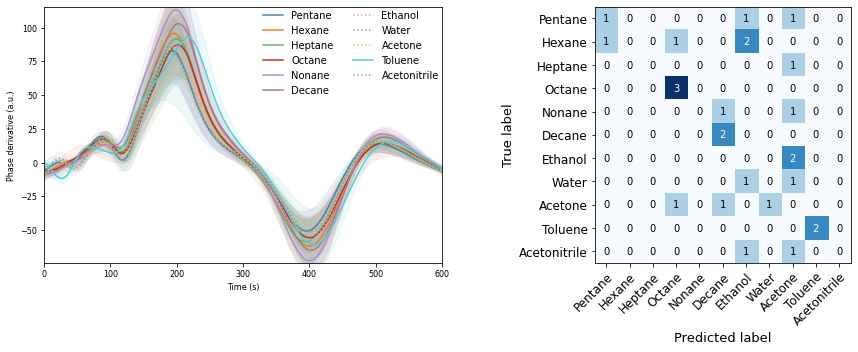

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, static_shift, [0,600], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()